# Modelling the Handwritten Dataset

From our previous notebook on [Understanding the Dataset](understanding_the_dataset), we look into what is entailed in our dataset (the [Hand Writing Digit Dataset](https://www.kaggle.com/competitions/digit-recognizer)). Now we'll proceed to processing the dataset and building a machine learning model to work with it.

We'll start by loading all the requirements for working with the data, as well as the data itself.

In [1]:
# Log settings
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

# Object Serializer
import joblib

# Data Manipulation Tools
import numpy as np
import pandas as pd

# Machine learning modelling
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
tf.autograph.set_verbosity(0)

# Machine learning model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Metrics visualization tools
import seaborn as sns
import matplotlib.pyplot as plt

Now we'll load and prepare the data for the model, we'll also split the model to have a validation set, so we can use this to validate if the model is underfitting or overfitting the dataset.

In [2]:
(trainX, trainy), (testX, testy) = mnist.load_data()
trainX, testX = trainX.reshape(60000, 784), testX.reshape(10000, 784)

trainX = trainX/255
testX = testX/255

In [3]:
trainX, valX, trainy, valy = train_test_split(
    trainX, trainy, test_size=.8333, 
    stratify=trainy, random_state=42
)

trainX.shape, valX.shape

((10002, 784), (49998, 784))

With that settled we can now create our model using the `tf.keras.models.Sequential` model. We'll be using 2 `Dense` hidden layers with 15 neurons each, with the relu activation and an output layer with linear activation and 10 neurons (one for each of the digits). 

In [4]:
tf.random.set_seed(42) 

model = Sequential(
    [               
        tf.keras.Input(shape=(784,)),
        Dense(15, activation='relu'),
        Dense(15, activation='relu'),
        Dense(10, activation='linear')
    ], name="hwdr_model" 
)

Quick summary of the model inner structure and summary

In [5]:
model.summary()

Model: "hwdr_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                11775     
                                                                 
 dense_1 (Dense)             (None, 15)                240       
                                                                 
 dense_2 (Dense)             (None, 10)                160       
                                                                 
Total params: 12,175
Trainable params: 12,175
Non-trainable params: 0
_________________________________________________________________


Now we can compile and fit the model on 50 epochs.

In [6]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [7]:
history = model.fit(trainX, trainy, epochs=50, validation_data=(valX, valy))

Epoch 1/50


2022-11-21 12:25:29.031606: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


313/313 [==============================] - 1s 3ms/step - loss: 1.1609 - accuracy: 0.6688 - val_loss: 0.5754 - val_accuracy: 0.8451
Epoch 2/50
313/313 [==============================] - 1s 2ms/step - loss: 0.4656 - accuracy: 0.8715 - val_loss: 0.3997 - val_accuracy: 0.8887
Epoch 3/50
313/313 [==============================] - 1s 2ms/step - loss: 0.3501 - accuracy: 0.9015 - val_loss: 0.3502 - val_accuracy: 0.8994
Epoch 4/50
313/313 [==============================] - 1s 2ms/step - loss: 0.3021 - accuracy: 0.9167 - val_loss: 0.3092 - val_accuracy: 0.9110
Epoch 5/50
313/313 [==============================] - 1s 2ms/step - loss: 0.2703 - accuracy: 0.9259 - val_loss: 0.2949 - val_accuracy: 0.9163
Epoch 6/50
313/313 [==============================] - 1s 2ms/step - loss: 0.2500 - accuracy: 0.9307 - val_loss: 0.2863 - val_accuracy: 0.9172
Epoch 7/50
313/313 [==============================] - 1s 2ms/step - loss: 0.2316 - accuracy: 0.9345 - val_loss: 0.2970 - val_accuracy: 0.9135
Epoch 8/50
313/31

We were able to track the activities of the model, by storing them in the history variable. We can now extend this to visualize how the model perform over each epoch.

In [8]:
history_track = pd.DataFrame(history.history)
history_track.head()

,loss,accuracy,val_loss,val_accuracy
0,1.160879,0.668766,0.575384,0.845074
1,0.465608,0.871526,0.399724,0.888736
2,0.350076,0.901520,0.350247,0.899376
3,0.302146,0.916717,0.309221,0.910956
4,0.270277,0.925915,0.294892,0.916277


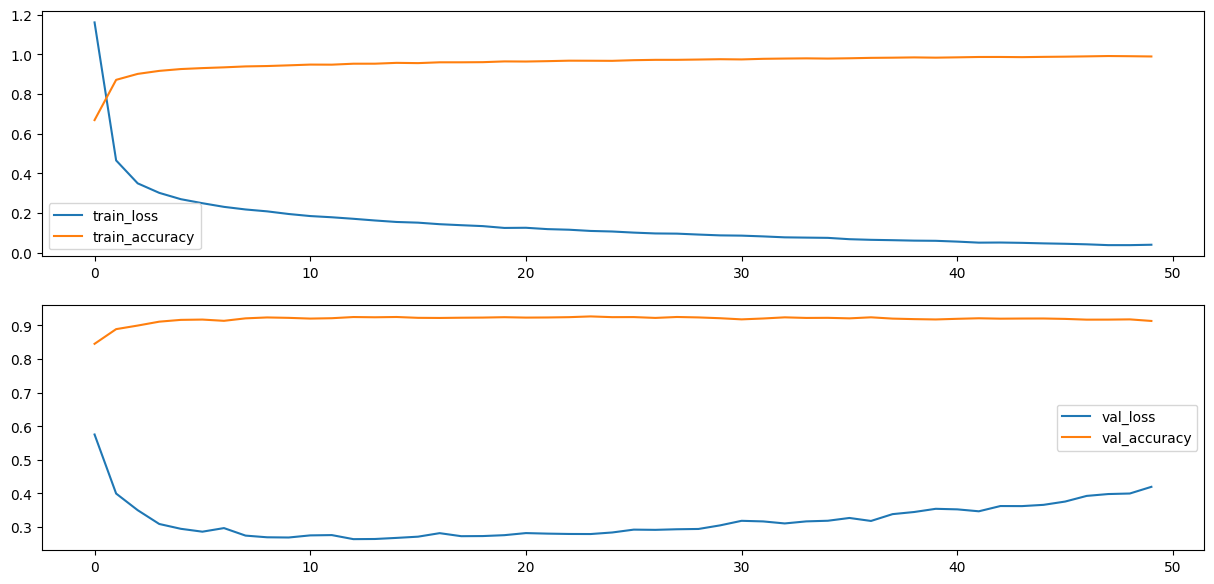

In [9]:
history_track = history_track.rename(columns={
    'loss': 'train_loss', 
    'accuracy': 'train_accuracy'
})

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 7))

history_track[['train_loss', 'train_accuracy']].plot(kind='line', ax=ax1)
history_track[['val_loss', 'val_accuracy']].plot(kind='line', ax=ax2);

We can see that the model didn't overfit nor underfit. And our model had a **98.93%** on the training set and **91.31%** on the validation set. That's good

Next thing we can check out is the measure of confusion our model has... you can read all about a confusion matrices [here](https://datatron.com/the-confusion-matrix/)

In [10]:
test_prediction = model.predict(testX).argmax(axis=1)

313/313 [==============================] - 0s 244us/step


In [11]:
accuracy_score(testy, test_prediction)

0.9132

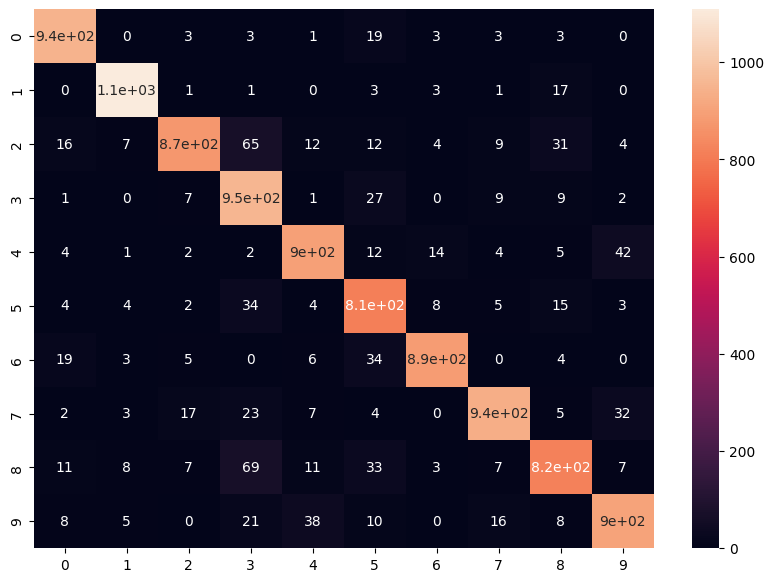

In [12]:
df_cm = pd.DataFrame(confusion_matrix(testy, test_prediction))
plt.figure(figsize=(10,7))
sns.heatmap(df_cm, annot=True);

Overall, we have created a fairly good model that was able to understand the 10 fundamental digits as we do... now in order to prepare an application to test our model we'll have to save our model.

In [13]:
joblib.dump(model, open('hwdr_model.z', 'wb'))

INFO:tensorflow:Assets written to: ram://b0fcfd65-41f6-45cc-9e9a-e0be31510191/assets


Finally, we'll extract some images from the test dataset into the [image directory](../images/) so we could use that to test and evaluate the model and see it's performance. See the process [here](extract_images.ipynb)